# H1N1 Vaccination Status Classification
**By [Czarina Luna](https://www.linkedin.com/in/czarinagluna/)**

### Contents
* [I. Overview](#I.-Overview)
* [II. Business Problem](#II.-Business-Problem)
* [III. Data Understanding](#III.-Data-Understanding)
* [IV. Classification Modeling](#IV.-Classification-Modeling)
* [V. Results and Recommendations](#V.-Results-and-Recommendations)
* [VI. Further Research](#VI.-Further-Research)

## I. Overview

An analysis and classification modeling of over 25,000 survey responses is completed to guide public health efforts on vaccination outreach. The highest accuracy and precision of 86% and 75% respectively is attained by the Extra Trees model predicting H1N1 vaccination status. According to the permutation importances of the model, the top features that affect H1N1 vaccination status are seasonal flu vaccination status, direct recommendation from a doctor, and health insurance.

## II. Business Problem 

Public health agencies may be able to improve their vaccination outreach by understanding people's opinions and behaviors that may be related with whether they receive the vaccine or not. Doing so will guide public health efforts such as education campaigns to focus on the characteristics that are likely to result to vaccination as supported by relevant data. Using national survey responses, I describe vaccination patterns and classify H1N1 vaccination status based on features such as opinions on risks of H1N1 and vaccine effectiveness, and behaviors towards mitigating H1N1 transmission.

## III. Data Understanding

The H1N1 Flu Survey from late 2009 and early 2010 collected over 25,000 responses and covered questions about the individual's social, economic, and demographic background, opinions about the virus and the vaccine, and behaviors like protective measures observed. The dependent variable to predict is `h1n1_vaccine` that is the individual's vaccination status. The features are described in the [data source](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/#features_list).

In [1]:
import pandas as pd
import numpy as np

labels = pd.read_csv('data/training_set_labels.csv')
features = pd.read_csv('data/training_set_features.csv')
data = pd.merge(features, labels, on='respondent_id').drop(columns='respondent_id')

# Quick look at the data structure
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Missing Values:

In [2]:
import warnings
warnings.filterwarnings('ignore')

null_values = pd.DataFrame(columns=['feature', 'null'])

# Check for null values
for col in data.columns:
    null_value = round((data[col].isnull().sum()/len(data)*100), 2)
    if null_value > 5:
        null_values = null_values.append({'feature':col, 'null':null_value}, ignore_index=True)

null_values

,feature,null
0,doctor_recc_h1n1,8.09
1,doctor_recc_seasonal,8.09
2,health_insurance,45.96
3,education,5.27
4,income_poverty,16.56
5,marital_status,5.27
6,rent_or_own,7.65
7,employment_status,5.48
8,employment_industry,49.91
9,employment_occupation,50.44


About half of the `employment_industry` and of `employment_occupation`, and almost half of the `health_insurance` values are missing. All the missing values are later imputed with the median for numerical features and the most frequent value for categorical features.

**Imbalanced Dataset**

In [3]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

The ratio of class `0` for not vaccinated to class `1` for vaccinated is 80:20 or more concisely 4:1. Random oversampling is implemented later to balance the class distribution.

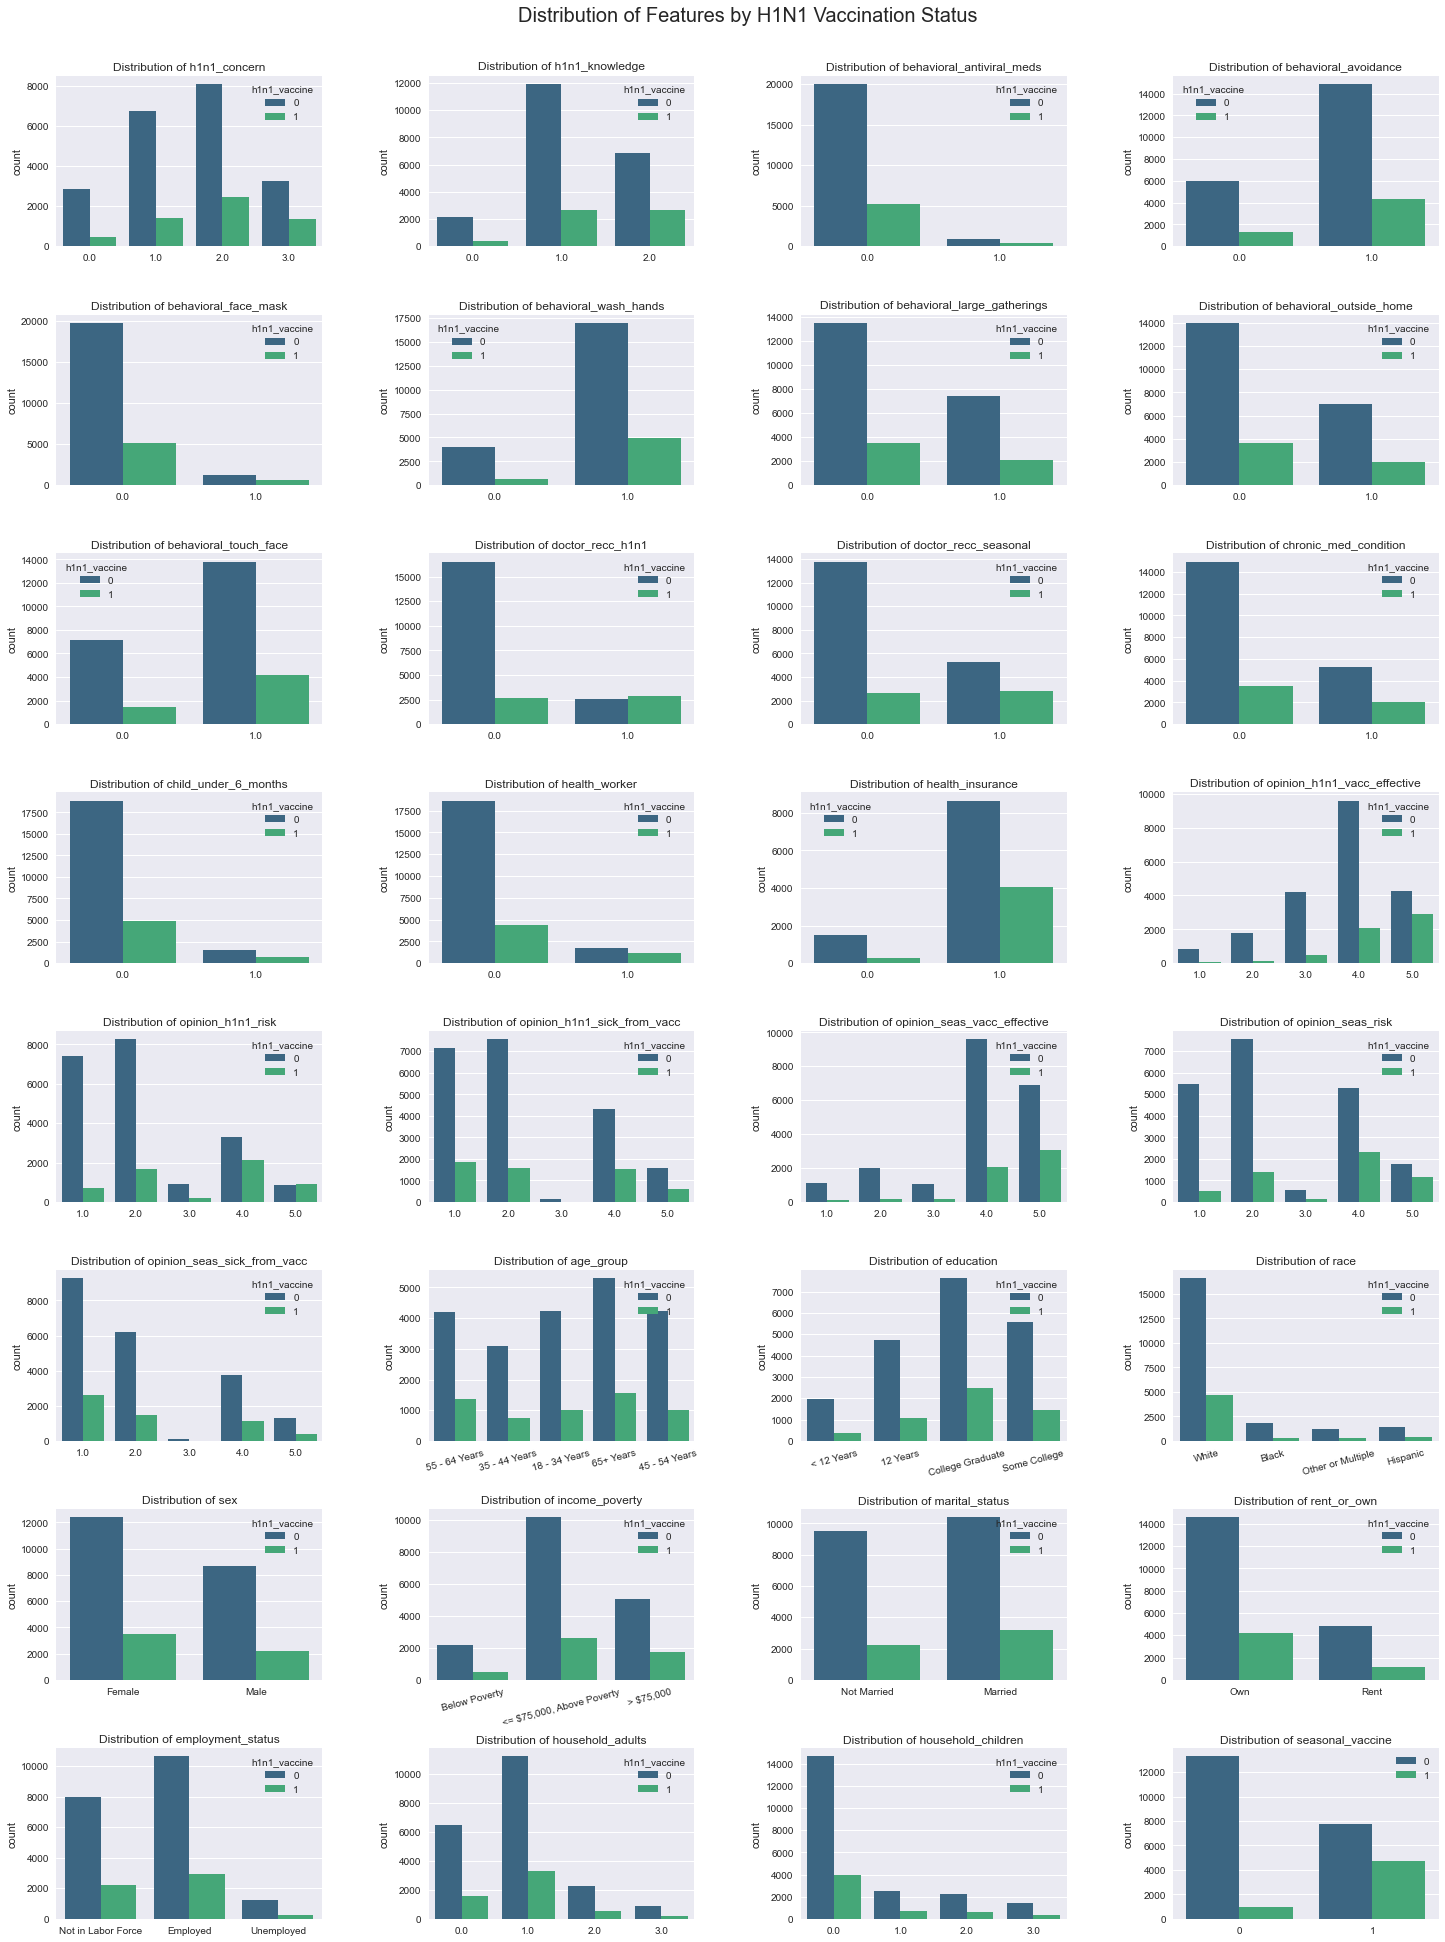

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
fig, axes = plt.subplots(8,4, figsize=(24,32))

to_drop = ['hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation', 'h1n1_vaccine']
to_rotate = ['age_group', 'education', 'race', 'income_poverty']

# Visualize data distribution
for idx, feature in enumerate(data.drop(columns=to_drop).columns):
    ax_tuple = (idx-32)//4, (idx-32)%4
    
    sns.countplot(x=feature, hue='h1n1_vaccine', data=data, ax=axes[ax_tuple], palette='viridis')
    axes[ax_tuple].set(xlabel=None, title=f'Distribution of {feature}')
    
    if feature in to_rotate:
        axes[ax_tuple].set_xticklabels(axes[ax_tuple].get_xticklabels(), rotation=15)

plt.suptitle(f'Distribution of Features by H1N1 Vaccination Status', fontsize=20, y=0.93)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.legend(loc='best')

plt.savefig(f'data/images/fig0.png', dpi=200, transparent=True) 
plt.show()

Due to the class imbalance, the counts for not vaccinated are higher than the vaccinated across the board. For almost all of the features, both classes follow the same distribution.

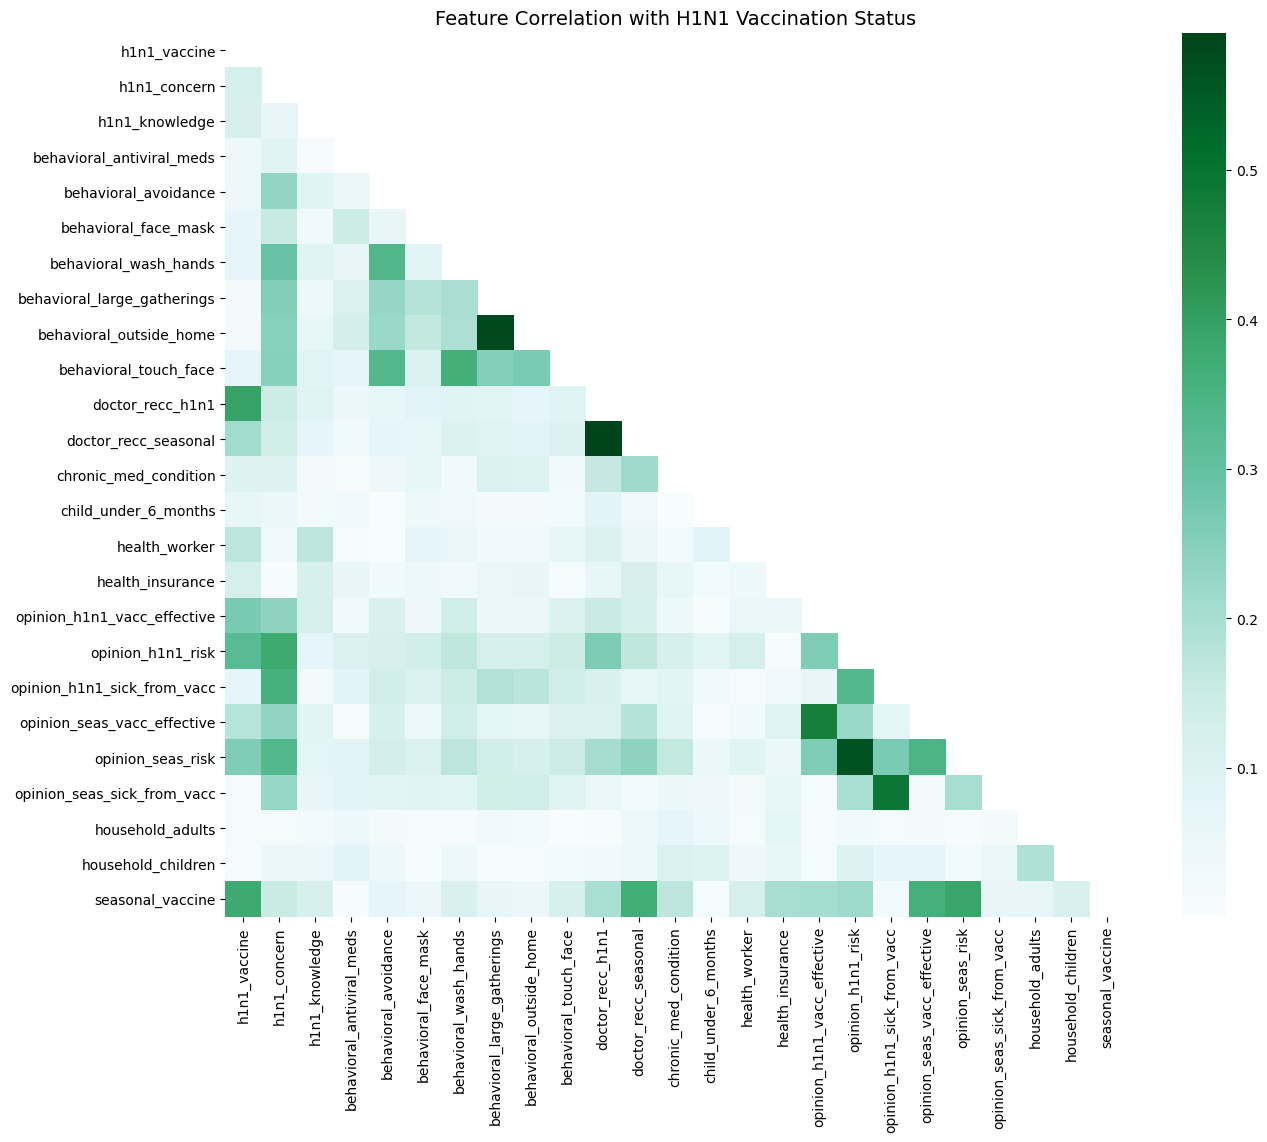

In [5]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 13))
plt.subplots_adjust(left=0.15, bottom=0.2)

h1n1_data = data.copy()
h1n1_feature = h1n1_data.pop('h1n1_vaccine')
h1n1_data.insert(0, 'h1n1_vaccine', h1n1_feature)

corr = h1n1_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlations among features
sns.heatmap(corr.abs(), mask=mask, cmap='BuGn')

plt.title('Feature Correlation with H1N1 Vaccination Status', fontsize=14)
plt.savefig('data/images/fig1.png', dpi=200, transparent=True)
plt.show()

The features with the strongest correlation with H1N1 vaccination status are `doctor_recc_h1n1`, `seasonal_vaccine`, `opinion_h1n1_risk`, and `opinion_h1n1_vacc_effective`.

## IV. Classification Modeling

**Baseline Model**

In [6]:
# Select only numerical features and drop missing values
baseline_data = data.select_dtypes(['float64', 'int64']).dropna()

Train Test Split:

In [7]:
from sklearn.model_selection import train_test_split

baseline_X = baseline_data.drop(columns=['h1n1_vaccine'])
baseline_y = baseline_data['h1n1_vaccine']

X_tr, X_te, y_tr, y_te = train_test_split(baseline_X, baseline_y, random_state=112221, stratify=baseline_y)

In [8]:
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression(random_state=112221)

baseline.fit(X_tr, y_tr)
baseline_pred = baseline.predict(X_te)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'''\
Accuracy: {round(accuracy_score(y_te, baseline_pred),2)}
Recall: {round(recall_score(y_te, baseline_pred),2)}
Precision: {round(precision_score(y_te, baseline_pred),2)}
F1-score: {round(f1_score(y_te, baseline_pred),2)}\
''')

Accuracy: 0.84
Recall: 0.66
Precision: 0.77
F1-score: 0.71


**Machine Learning Pipeline**

To automate the machine learning workflow, I put together a pipeline that imputes missing values, standardizes numerical features, and one hot encodes the categorical features.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median', add_indicator=True)), 
           ('scaler', StandardScaler())])

categorical_transformer = Pipeline(
    steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
           ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

num_features = list(range(0, 21)) + [31, 32]
cat_features = list(range(21, 31)) + [33, 34, 35]

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_features),
                  ('cat', categorical_transformer, cat_features)], remainder='passthrough')

In [11]:
# Store for retrieval in grid search notebook
%store preprocessor

Stored 'preprocessor' (ColumnTransformer)


In [12]:
X = data.drop(columns=['h1n1_vaccine'])
y = data['h1n1_vaccine']

# Train test split on data using all features
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

In [13]:
# Store for retrieval in grid search notebook
%store X_train

Stored 'X_train' (DataFrame)


In [14]:
# Store for retrieval in grid search notebook
%store y_train

Stored 'y_train' (Series)


In [15]:
import time

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve

def run_model(models, model_type, X_train=X_train, y_train=y_train):
    '''
    Fits classification model on train set, predicts on test set, and returns metrics per model
    '''
    model_curves = pd.DataFrame(columns=['model', 'precision', 'recall', 'fpr', 'tpr'])
    metric_table = pd.DataFrame(columns=['model', 'cv_score', 'accuracy', 'precision', 'recall', 'f1_score', 'auc_score', 'type'])
    
    for name, model in models.items():
        print(f'Running... {name} Model')
        print(f'Time Started: {time.asctime()}')
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model['classifier'])])
        pipeline.fit(X_train, y_train)
        
        cross_val = cross_val_score(pipeline, X_train, y_train, cv=3)
        cross_val_mean = round(np.mean(cross_val), 4)
        
        y_pred = pipeline.predict(X_test)
        y_score = pipeline.predict_proba(X_test)[:,1]
        
        precision_arr, recall_arr, _ = precision_recall_curve(y_test, y_score)
        false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
        model_curves = model_curves.append({'model': name, 'precision': precision_arr, 'recall': recall_arr, 
                                            'fpr': false_positive_rate, 'tpr': true_positive_rate}, ignore_index=True)
        
        accuracy = round(accuracy_score(y_test, y_pred), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)
        auc = round(roc_auc_score(y_test, y_pred), 4)
        
        metric_table = metric_table.append({'model': name, 'cv_score': cross_val_mean, 'accuracy': accuracy, 'precision': precision, 
                                            'recall': recall, 'f1_score': f1, 'auc_score': auc, 'type': model_type}, ignore_index=True)
        print(f'Time Finished: {time.asctime()}\n')
        
    return model_curves, metric_table

Let's run the following classification models with default parameters:

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

default_models = {'LogisticRegression': {'classifier': LogisticRegression(random_state=112221)},
                  'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=112221)},
                  'RandomForest': {'classifier': RandomForestClassifier(random_state=112221)},
                  'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=112221)},
                  'GradientBoost': {'classifier': GradientBoostingClassifier(random_state=112221)}}

default_curves, default_metrics = run_model(default_models, 'Default')

Running... LogisticRegression Model
Time Started: Fri May  6 01:50:58 2022
Time Finished: Fri May  6 01:51:06 2022

Running... DecisionTree Model
Time Started: Fri May  6 01:51:06 2022
Time Finished: Fri May  6 01:51:14 2022

Running... RandomForest Model
Time Started: Fri May  6 01:51:14 2022
Time Finished: Fri May  6 01:51:37 2022

Running... ExtraTrees Model
Time Started: Fri May  6 01:51:37 2022
Time Finished: Fri May  6 01:52:08 2022

Running... GradientBoost Model
Time Started: Fri May  6 01:52:08 2022
Time Finished: Fri May  6 01:53:24 2022



In [17]:
default_metrics

,model,cv_score,accuracy,precision,recall,f1_score,auc_score,type
0,LogisticRegression,0.8669,0.8612,0.7212,0.5652,0.6337,0.7531,Default
1,DecisionTree,0.8009,0.8017,0.5329,0.5426,0.5377,0.7071,Default
2,RandomForest,0.8633,0.857,0.75,0.4905,0.5931,0.7232,Default
3,ExtraTrees,0.8641,0.8607,0.7497,0.5173,0.6122,0.7353,Default
4,GradientBoost,0.8706,0.8664,0.7424,0.5687,0.6441,0.7577,Default


**Classification Metrics**

Accuracy only reflects the underlying class distribution in an imbalanced dataset. If a model predicts not vaccinated all the time, it is already 80% accurate. So other classification metrics are used to measure the success of predictions. 

- Precision measures how many are actually vaccinated out of all the people predicted to be vaccinated
- Recall measures how many are correctly predicted to be vaccinated out of all the total vaccinated people

Precision-recall curve is plotted below to show the tradeoff between the two. The AUC score is the area under the ROC curve that is plotted, too. It measures the performance of models across all classification thresholds.

In [18]:
default_curves

,model,precision,recall,fpr,tpr
0,LogisticRegression,"[0.22099361470175985, 0.22087227414330218, 0.2...","[1.0, 0.9992952783650458, 0.9992952783650458, ...","[0.0, 0.0, 0.0, 0.0001901863826550019, 0.00019...","[0.0, 0.0007047216349541931, 0.002114164904862..."
1,DecisionTree,"[0.21252059308072488, 0.532871972318339, 1.0]","[1.0, 0.5426356589147286, 0.0]","[0.0, 0.12837580829212628, 1.0]","[0.0, 0.5426356589147286, 1.0]"
2,RandomForest,"[0.21252059308072488, 0.22081772784019976, 0.2...","[1.0, 0.9971811134601832, 0.9936575052854123, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003803727653...","[0.0, 0.0007047216349541931, 0.002114164904862..."
3,ExtraTrees,"[0.21252059308072488, 0.2227458372604461, 0.23...","[1.0, 0.9992952783650458, 0.9957716701902748, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000190186382655001...","[0.0, 0.0007047216349541931, 0.002114164904862..."
4,GradientBoost,"[0.2188463911165947, 0.2187258985037791, 0.218...","[1.0, 0.9992952783650458, 0.9992952783650458, ...","[0.0, 0.0001901863826550019, 0.000190186382655...","[0.0, 0.0, 0.007751937984496124, 0.00775193798..."


In [19]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_model(model_curves, title, fig_name):
    '''
    Plots precision-recall curve, and false positive rate against true positive rate for AUC-ROC curve
    '''
    colors = ['#F66D44', "#F1A104", '#AADEA7', "#25B396", "#00743F"]
    
    plt.style.use('bmh')
    fig, axes = plt.subplots(ncols=2, figsize=(15,7))
    
    for i, color in zip(range(len(model_curves)), colors):
        display = PrecisionRecallDisplay(precision=model_curves.loc[i,'precision'], recall=model_curves.loc[i,'recall'])
        display.plot(name=model_curves.loc[i,'model'], color=color, ax=axes[0])
        axes[1].plot(model_curves.loc[i,'fpr'], model_curves.loc[i,'tpr'], color=color, lw=2, label=model_curves.loc[i,'model'])
        
    axes[0].set(title='Precision Recall Curve', xlim=[0.0, 1.0], ylim=[0.0, 1.01])
    axes[0].legend(loc='lower left')
    
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1].set(title='ROC Curve', xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=[0.0, 1.0], ylim=[0.0, 1.01])
    axes[1].legend(loc='lower right')
    
    plt.suptitle(title, fontsize=16)
    plt.savefig(f'data/images/{fig_name}.png', dpi=200, transparent=True) 
    plt.show()

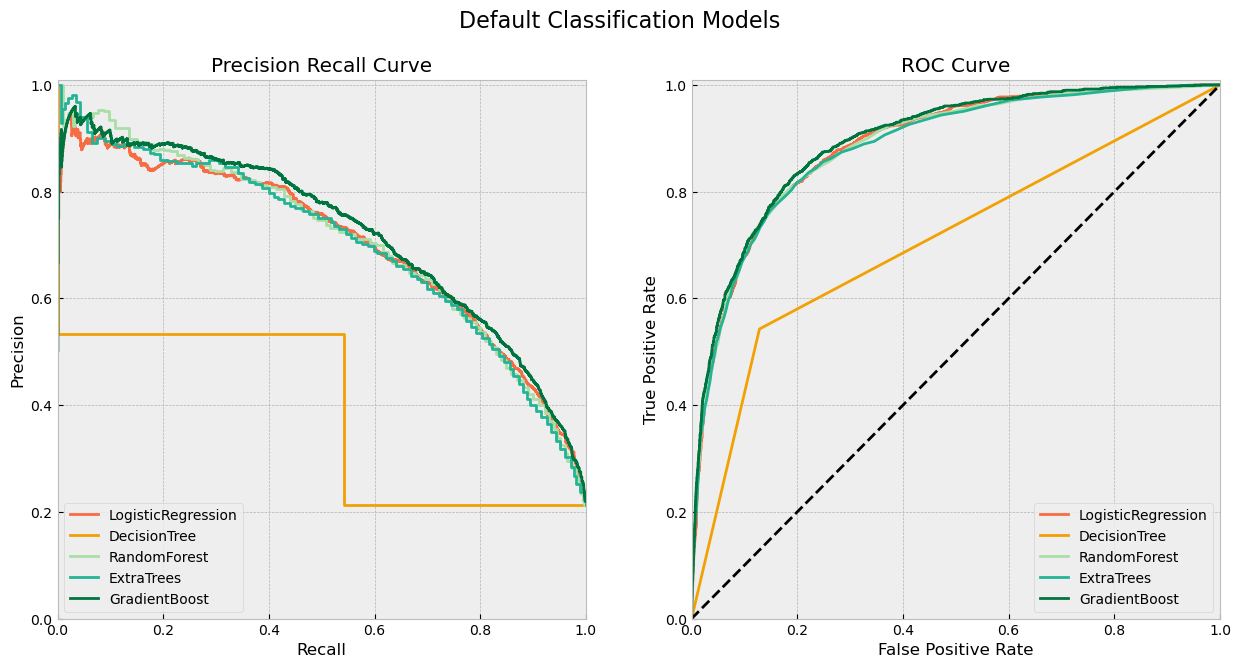

In [20]:
plot_model(default_curves, 'Default Classification Models', 'fig2')

**Random Oversampling**

To balance the class distribution, random oversampling is done by randomly duplicating examples of the minority class `1` in the training set.

In [21]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority', random_state=112221)
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

In [22]:
# Store for retrieval in grid search notebook
%store X_train_res

Stored 'X_train_res' (DataFrame)


In [23]:
# Store for retrieval in grid search notebook
%store y_train_res

Stored 'y_train_res' (Series)


Let's rerun the classification models with default parameters on the resampled data:

In [24]:
oversample_curves, oversample_metrics = run_model(default_models, 'Oversample', X_train_res, y_train_res)

Running... LogisticRegression Model
Time Started: Fri May  6 01:53:29 2022
Time Finished: Fri May  6 01:53:55 2022

Running... DecisionTree Model
Time Started: Fri May  6 01:53:55 2022
Time Finished: Fri May  6 01:54:16 2022

Running... RandomForest Model
Time Started: Fri May  6 01:54:16 2022
Time Finished: Fri May  6 01:54:59 2022

Running... ExtraTrees Model
Time Started: Fri May  6 01:54:59 2022
Time Finished: Fri May  6 01:55:53 2022

Running... GradientBoost Model
Time Started: Fri May  6 01:55:53 2022
Time Finished: Fri May  6 01:58:27 2022



In [25]:
oversample_metrics

,model,cv_score,accuracy,precision,recall,f1_score,auc_score,type
0,LogisticRegression,0.8204,0.8111,0.5374,0.8006,0.6431,0.8073,Oversample
1,DecisionTree,0.9132,0.8031,0.5368,0.5349,0.5358,0.7052,Oversample
2,RandomForest,0.9499,0.8568,0.6931,0.5856,0.6348,0.7578,Oversample
3,ExtraTrees,0.963,0.858,0.7513,0.4961,0.5976,0.7259,Oversample
4,GradientBoost,0.8296,0.821,0.5543,0.8062,0.6569,0.8156,Oversample


In [26]:
oversample_metrics

,model,cv_score,accuracy,precision,recall,f1_score,auc_score,type
0,LogisticRegression,0.8204,0.8111,0.5374,0.8006,0.6431,0.8073,Oversample
1,DecisionTree,0.9132,0.8031,0.5368,0.5349,0.5358,0.7052,Oversample
2,RandomForest,0.9499,0.8568,0.6931,0.5856,0.6348,0.7578,Oversample
3,ExtraTrees,0.963,0.858,0.7513,0.4961,0.5976,0.7259,Oversample
4,GradientBoost,0.8296,0.821,0.5543,0.8062,0.6569,0.8156,Oversample


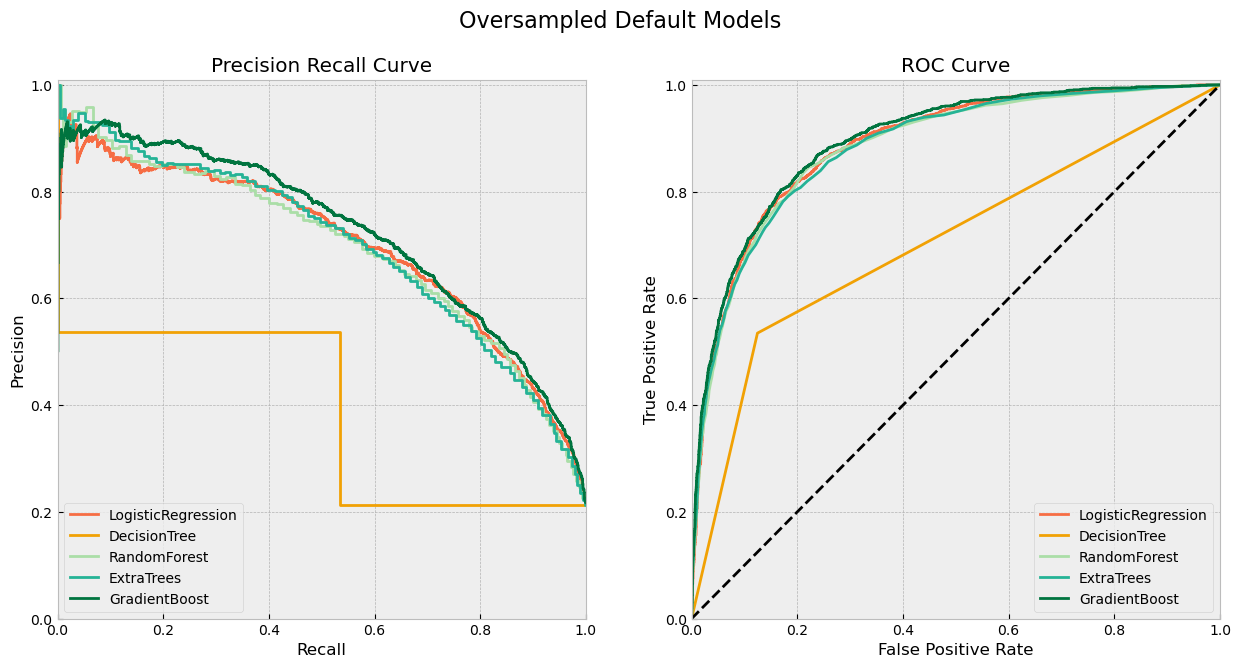

In [27]:
plot_model(oversample_curves, 'Oversampled Default Models', 'fig3')

**Hyperparameter Tuning**

I implement a grid search in a separate [notebook](https://github.com/czarinagluna/vaccination-status-classification/blob/main/GridSearch.ipynb) to find the optimal parameters of the classification models that are used below:

In [28]:
def optimize_model(models, classifier, classifier_name, params):
    '''
    Uses optimal parameters found from grid search to tune model's hyperparameters
    '''
    best_params = {}
    
    for param, values in params.items():
        parameter = param.replace('classifier__', '')
        best_params[parameter] = values
        
    models[classifier_name]['classifier'] = classifier(**best_params)

In [29]:
tuned_models = default_models.copy()

Logistic Regression:

In [30]:
# Retrieve optimal parameters from grid search notebook
%store -r lr_best_params

In [31]:
optimize_model(tuned_models, LogisticRegression, 'LogisticRegression', lr_best_params)

Decision Tree:

In [32]:
# Retrieve optimal parameters from grid search notebook
%store -r dt_best_params

In [33]:
optimize_model(tuned_models, DecisionTreeClassifier, 'DecisionTree', dt_best_params)

Random Forest:

In [34]:
# Retrieve optimal parameters from grid search notebook
%store -r rf_best_params

In [35]:
optimize_model(tuned_models, RandomForestClassifier, 'RandomForest', rf_best_params)

Extra Trees:

In [36]:
# Retrieve optimal parameters from grid search notebook
%store -r et_best_params

In [37]:
optimize_model(tuned_models, ExtraTreesClassifier, 'ExtraTrees', et_best_params)

Gradient Boost:

In [38]:
# Retrieve optimal parameters from grid search notebook
%store -r gb_best_params

In [39]:
optimize_model(tuned_models, GradientBoostingClassifier, 'GradientBoost', gb_best_params)

***

In [40]:
tuned_models

{'LogisticRegression': {'classifier': LogisticRegression(C=1, penalty='l1', solver='saga')},
 'DecisionTree': {'classifier': DecisionTreeClassifier(criterion='entropy')},
 'RandomForest': {'classifier': RandomForestClassifier(n_estimators=30)},
 'ExtraTrees': {'classifier': ExtraTreesClassifier(n_estimators=30)},
 'GradientBoost': {'classifier': GradientBoostingClassifier(max_depth=None, min_samples_leaf=5)}}

Finally, let's run the classification models with tuned parameters:

In [41]:
tuned_curves, tuned_metrics = run_model(tuned_models, 'Tuned', X_train_res, y_train_res)

Running... LogisticRegression Model
Time Started: Fri May  6 01:58:30 2022
Time Finished: Fri May  6 01:59:26 2022

Running... DecisionTree Model
Time Started: Fri May  6 01:59:26 2022
Time Finished: Fri May  6 01:59:44 2022

Running... RandomForest Model
Time Started: Fri May  6 01:59:44 2022
Time Finished: Fri May  6 02:00:09 2022

Running... ExtraTrees Model
Time Started: Fri May  6 02:00:09 2022
Time Finished: Fri May  6 02:00:42 2022

Running... GradientBoost Model
Time Started: Fri May  6 02:00:42 2022
Time Finished: Fri May  6 02:09:39 2022



In [42]:
tuned_metrics

,model,cv_score,accuracy,precision,recall,f1_score,auc_score,type
0,LogisticRegression,0.8205,0.8114,0.5378,0.8027,0.644,0.8082,Tuned
1,DecisionTree,0.914,0.8065,0.5438,0.5553,0.5495,0.7148,Tuned
2,RandomForest,0.9497,0.8562,0.694,0.5786,0.6311,0.7549,Tuned
3,ExtraTrees,0.9638,0.854,0.7429,0.4785,0.5821,0.7169,Tuned
4,GradientBoost,0.9485,0.8588,0.6904,0.6082,0.6467,0.7673,Tuned


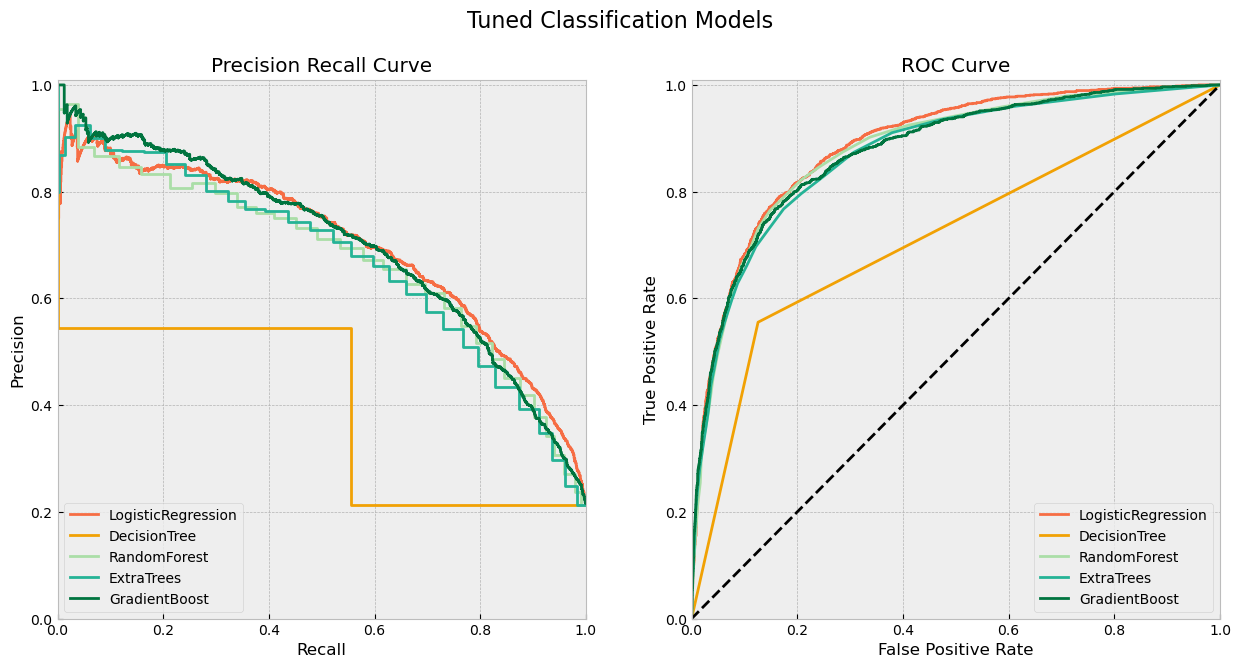

In [43]:
plot_model(tuned_curves, 'Tuned Classification Models', 'fig4')

In [44]:
# All models and metrics in one dataframe
all_models = pd.concat([default_metrics, oversample_metrics, tuned_metrics], ignore_index=True)
all_models

,model,cv_score,accuracy,precision,recall,f1_score,auc_score,type
0,LogisticRegression,0.8669,0.8612,0.7212,0.5652,0.6337,0.7531,Default
1,DecisionTree,0.8009,0.8017,0.5329,0.5426,0.5377,0.7071,Default
2,RandomForest,0.8633,0.857,0.75,0.4905,0.5931,0.7232,Default
3,ExtraTrees,0.8641,0.8607,0.7497,0.5173,0.6122,0.7353,Default
4,GradientBoost,0.8706,0.8664,0.7424,0.5687,0.6441,0.7577,Default
5,LogisticRegression,0.8204,0.8111,0.5374,0.8006,0.6431,0.8073,Oversample
6,DecisionTree,0.9132,0.8031,0.5368,0.5349,0.5358,0.7052,Oversample
7,RandomForest,0.9499,0.8568,0.6931,0.5856,0.6348,0.7578,Oversample
8,ExtraTrees,0.963,0.858,0.7513,0.4961,0.5976,0.7259,Oversample
9,GradientBoost,0.8296,0.821,0.5543,0.8062,0.6569,0.8156,Oversample


Out of all the models, the tuned `ExtraTrees` has the highest cross validation score for accuracy and the highest precision score, too.

## V. Results and Recommendations

Model Performance:

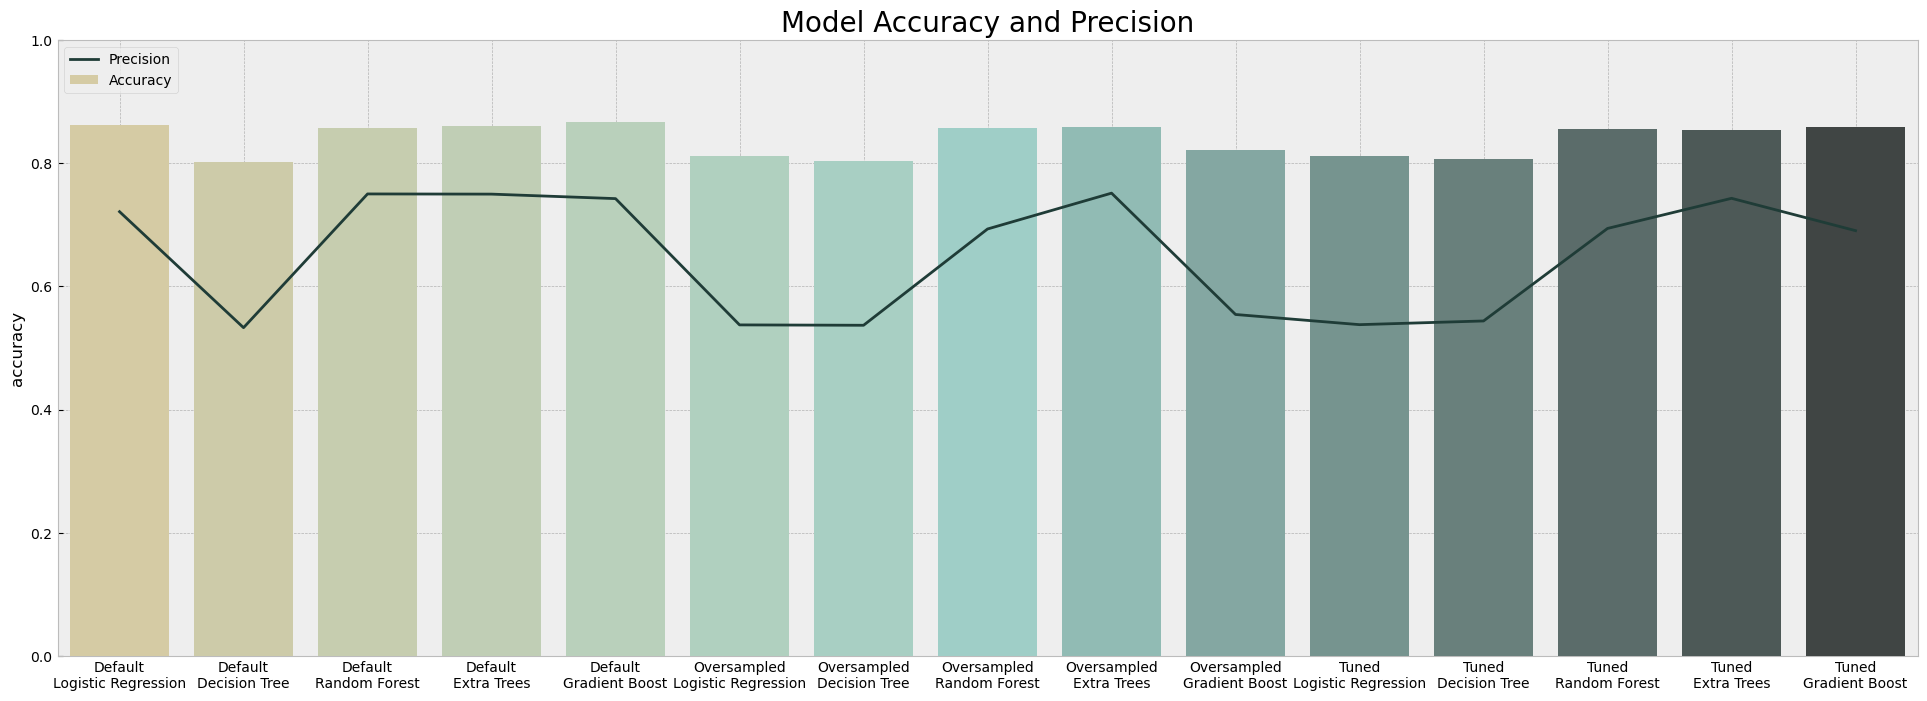

In [45]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(24, 8))
ax.set(xlim=[-0.5, 14.5], ylim=[0.0, 1.0], ylabel='Score')

# Plot the accuracy and precision of all models
sns.barplot(all_models.index, all_models['accuracy'], palette='BrBG_d', label='Accuracy', zorder=99) 
plt.plot(all_models.index, all_models['precision'], color='#1f3c37', label='Precision', zorder=99)

labels = ['Default\nLogistic Regression', 'Default\nDecision Tree', 'Default\nRandom Forest', 'Default\nExtra Trees', 'Default\nGradient Boost', 
          'Oversampled\nLogistic Regression', 'Oversampled\nDecision Tree', 'Oversampled\nRandom Forest', 'Oversampled\nExtra Trees', 'Oversampled\nGradient Boost', 
          'Tuned\nLogistic Regression', 'Tuned\nDecision Tree', 'Tuned\nRandom Forest', 'Tuned\nExtra Trees', 'Tuned\nGradient Boost']

plt.xticks(all_models.index, labels)
plt.title('Model Accuracy and Precision', fontsize=20)
plt.legend(loc='upper left')

plt.grid(axis='x')
plt.savefig('data/images/fig5.png', dpi=200, transparent=True)
plt.show()

**Final Model**

In [46]:
final_model = tuned_models['ExtraTrees']['classifier']
final = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', final_model)])

final.fit(X_train_res, y_train_res)
final_pred = final.predict(X_test)

In [47]:
print(f'''\
Accuracy: {round(accuracy_score(y_test, final_pred),2)}
Recall: {round(recall_score(y_test, final_pred),2)}
Precision: {round(precision_score(y_test, final_pred),2)}
F1-score: {round(f1_score(y_test, final_pred),2)}\
''')

Accuracy: 0.86
Recall: 0.48
Precision: 0.75
F1-score: 0.59


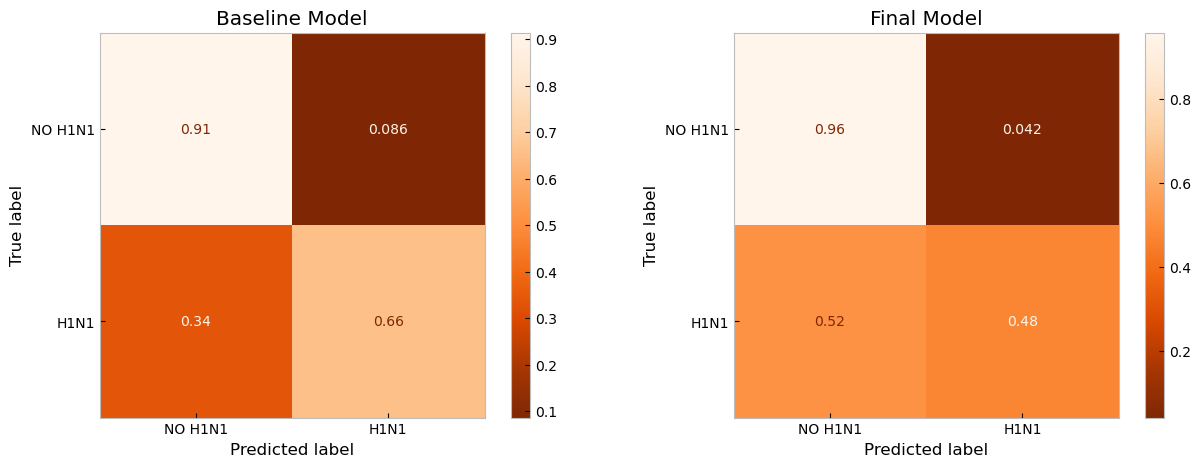

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Plot the confusion matrix of the baseline model
baseline_cf = confusion_matrix(y_te, baseline_pred, normalize='true')
baseline_matrix = ConfusionMatrixDisplay(baseline_cf, display_labels=['NO H1N1', 'H1N1'])
baseline_matrix.plot(ax=axes[0], cmap='Oranges_r')

# Plot the confusion matrix of the final model
final_cf = confusion_matrix(y_test, final_pred, normalize='true')
final_matrix = ConfusionMatrixDisplay(final_cf, display_labels=['NO H1N1', 'H1N1'])
final_matrix.plot(ax=axes[1], cmap='Oranges_r')

axes[0].grid()
axes[1].grid()
axes[0].set_title('Baseline Model')
axes[1].set_title('Final Model')

plt.savefig('data/images/fig6.png', dpi=200, transparent=True)
plt.show()

Comparing the confusion matrices of the baseline model and the final model, the false positive is reduced by half from 0.086 to 0.042 under the final model.

***

Permutation Importances:

> "Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but **how important this feature is for a particular model**." ([scikit-learn](https://scikit-learn.org/stable/modules/permutation_importance.html))

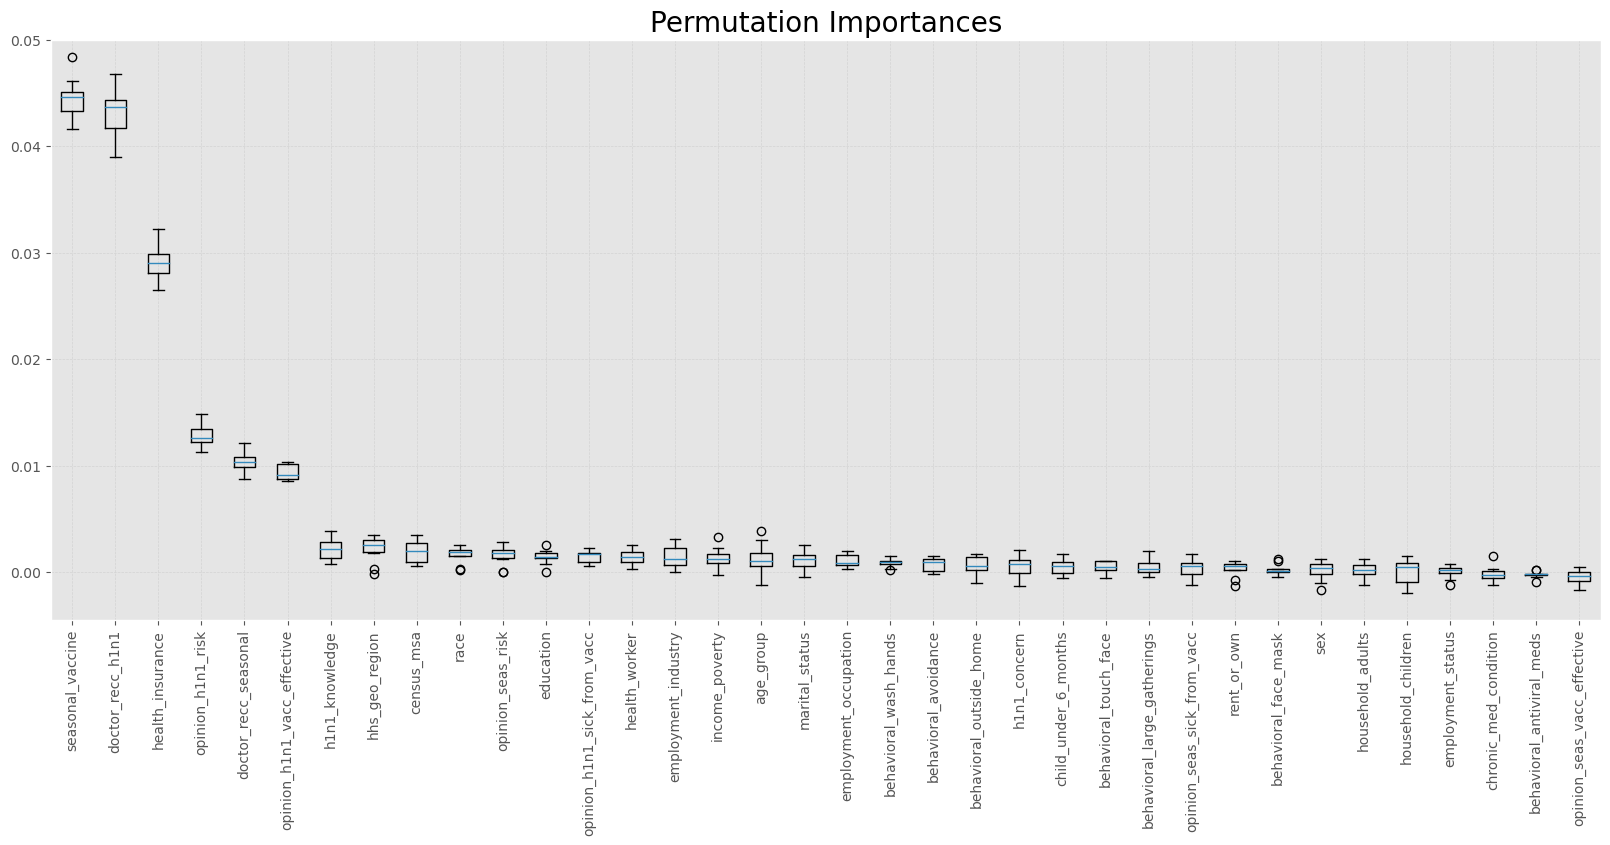

In [50]:
from sklearn.inspection import permutation_importance

result = permutation_importance(final, X_test, y_test, n_repeats=10, random_state=112221, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.subplots_adjust(bottom=0.3)

# Plot the permutation importances of the final model
ax.boxplot(result.importances[sorted_idx].T, vert=True)

ax.set_ylim(top=0.05)
ax.set_title('Permutation Importances', fontsize=20)
ax.set_xticklabels(X_test.columns[sorted_idx], rotation=90)

plt.grid(linestyle='--', color='lightgray')
plt.savefig('data/images/fig7.png', dpi=200, transparent=True)
plt.show()

The top features that affect H1N1 vaccination status on the final model are `seasonal_vaccine`, `doctor_recc_h1n1`, and `health_insurance`. 

**Recommendations**

- Direct efforts to individuals who receive the seasonal flu vaccine by providing information about and reminders to receive the H1N1 vaccine, too.
- Coordinate with primary health care providers to educate and recommend the vaccine to patients.
- Focus vaccination campaigns on a message that the vaccines are free and available for the uninsured.

***

**Model Deployment**

Finally, I deploy the Extra Trees classifier model as an online survey to demonstrate the prediction of vaccination status after answering the questions.

## VI. Further Research

For further research, the data should be updated with more recent survey responses, and additional questions could be asked. 

# Contact
Feel free to contact me for any questions and connect with me on [Linkedin](https://www.linkedin.com/in/czarinagluna).